<a href="https://colab.research.google.com/github/akhil14shukla/IME672A-Course-Project/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the required libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import ppscore as pps
from sklearn import metrics               
from sklearn import preprocessing
from sklearn import utils
%matplotlib inline

Taking csv data as input

In [15]:
df = pd.read_csv("https://raw.githubusercontent.com/akhil14shukla/IME672A-Course-Project/master/hmeq.csv")


In [16]:
# sns.pairplot(df)

## Understanding the Data

In [17]:
print(df.dtypes)

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object


Most of the data is already numerical, only two are of strings type (_REASON_ and _JOB_).

In [18]:
# Seeing the count of missing or null values
df.isna().sum(axis=0)

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [19]:
print(df["REASON"].value_counts())
print(df["JOB"].value_counts())

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


**We need to fill these two variable's null values and OneHot Encode them to plot their distribution efficiently.<br><br>**
Reason/Meaning of null values in REASON and JOB, and how we will fill these:<br><br>

We can fill the missing value with 
* a new value _"Unknown"_ 
* Fill the missing values based on the distribution of non-missing values
* Replace them with the most frequent value  
* Predicting the missing values using another attribute and Decision Tree.
<br><br>
[//]: # (Hello)
REASON - This shows the reason why the person is taking the loan. There are two available values : Debt consolidation and Home Improvement. The missing value must be showing that the Reason of taking the loan was not either of the two given optins and hence was left empty. So, **filling the missing values with a new value _"Other"_, for this attribute**.<br><br>
JOB - This tells the occupation of the applicant. There are 6 unique values for this attribute, and the value _"Other"_ is the most frequent. The _"Other"_ value is already present, so it rules out the reasoning used above. Out of the remaining options, we can **replace the missing values with the most frequent value for simplicity**<br><br>

In [5]:
df["REASON"].fillna("Other reason",inplace=True)

In [6]:
print(df["JOB"].isna().sum())
print(df["JOB"].value_counts())
# We can fill the missing values with the mode, i.e. "Other", or we can fill the missing values depending on the distribution of the non-null values. 
df["JOB"].fillna(df["JOB"].mode()[0],inplace=True)
print(df["JOB"].isna().sum())

279
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64
0


In [7]:
df = df.join(pd.get_dummies(df["JOB"]))
df = df.join(pd.get_dummies(df["REASON"]))
df.drop(["JOB", "REASON"],axis=1, inplace=True)

_We have only filled the missing or null value of REASON and JOB, because they are of string type and we need to convert them to numerical before we can analyse the Attributes. Other Attributes will be cleaned after Analysis._
<br><br>Plotting Boxplots for each attribute in df

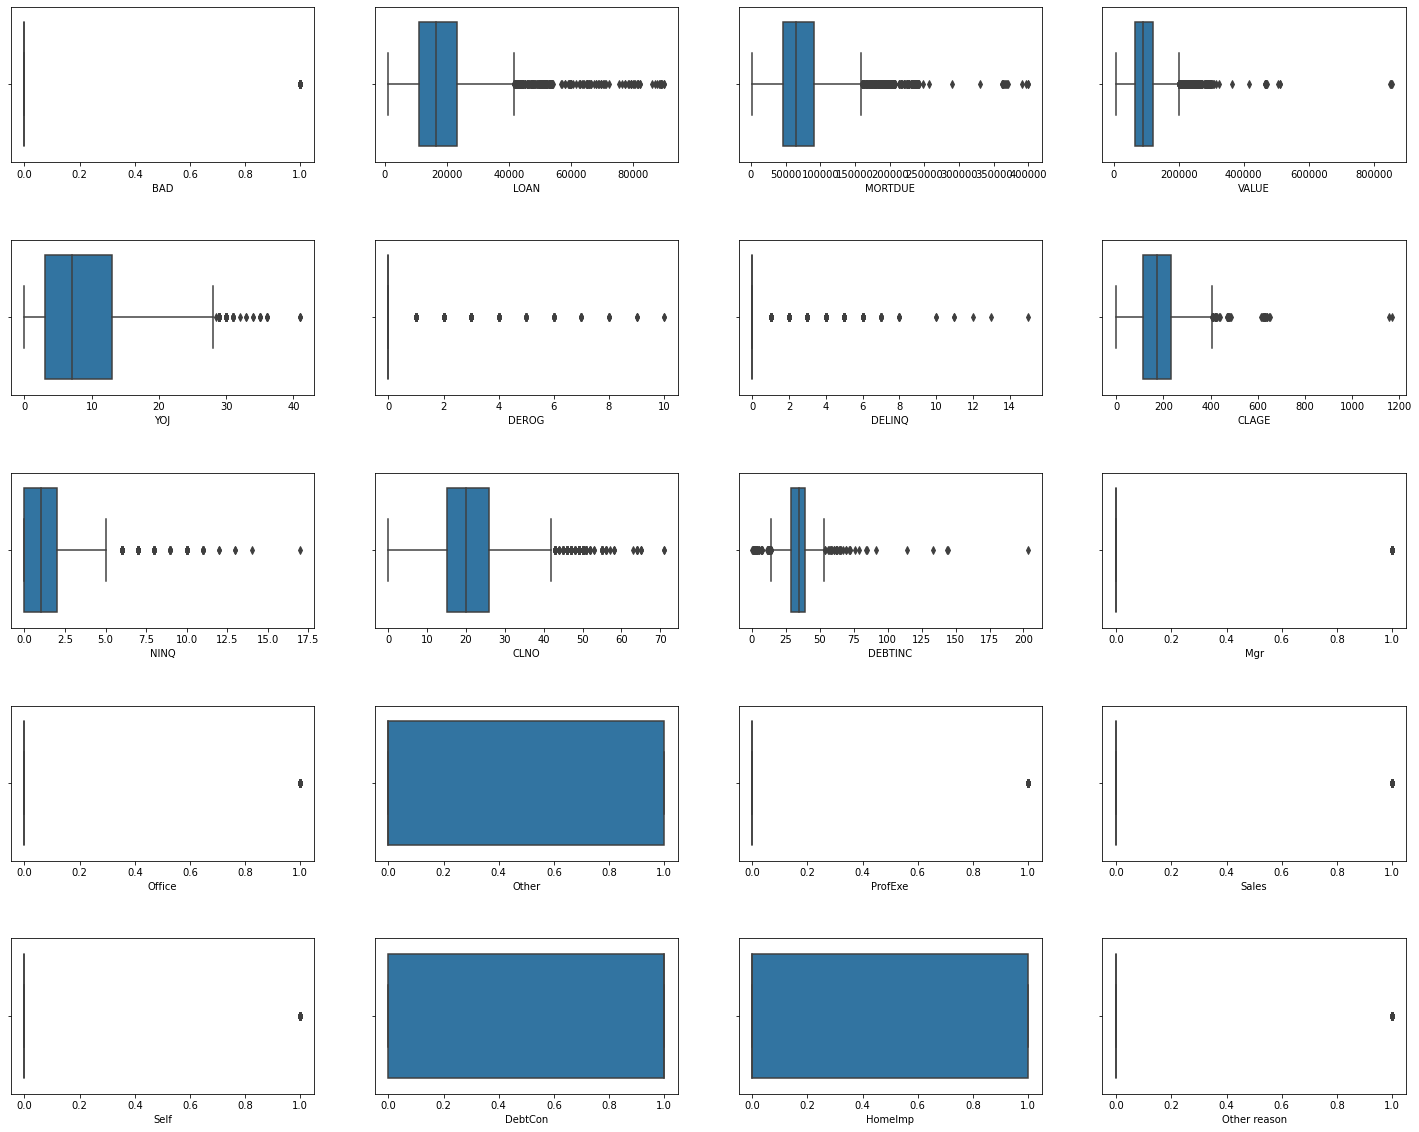

In [8]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20),)
for i,ax in zip(df.columns,axes.flat):
    sns.boxplot(data=df, x=i,ax=ax)     # we can also use violin plot 
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Plotting Histograms to see the distribution of each attribute

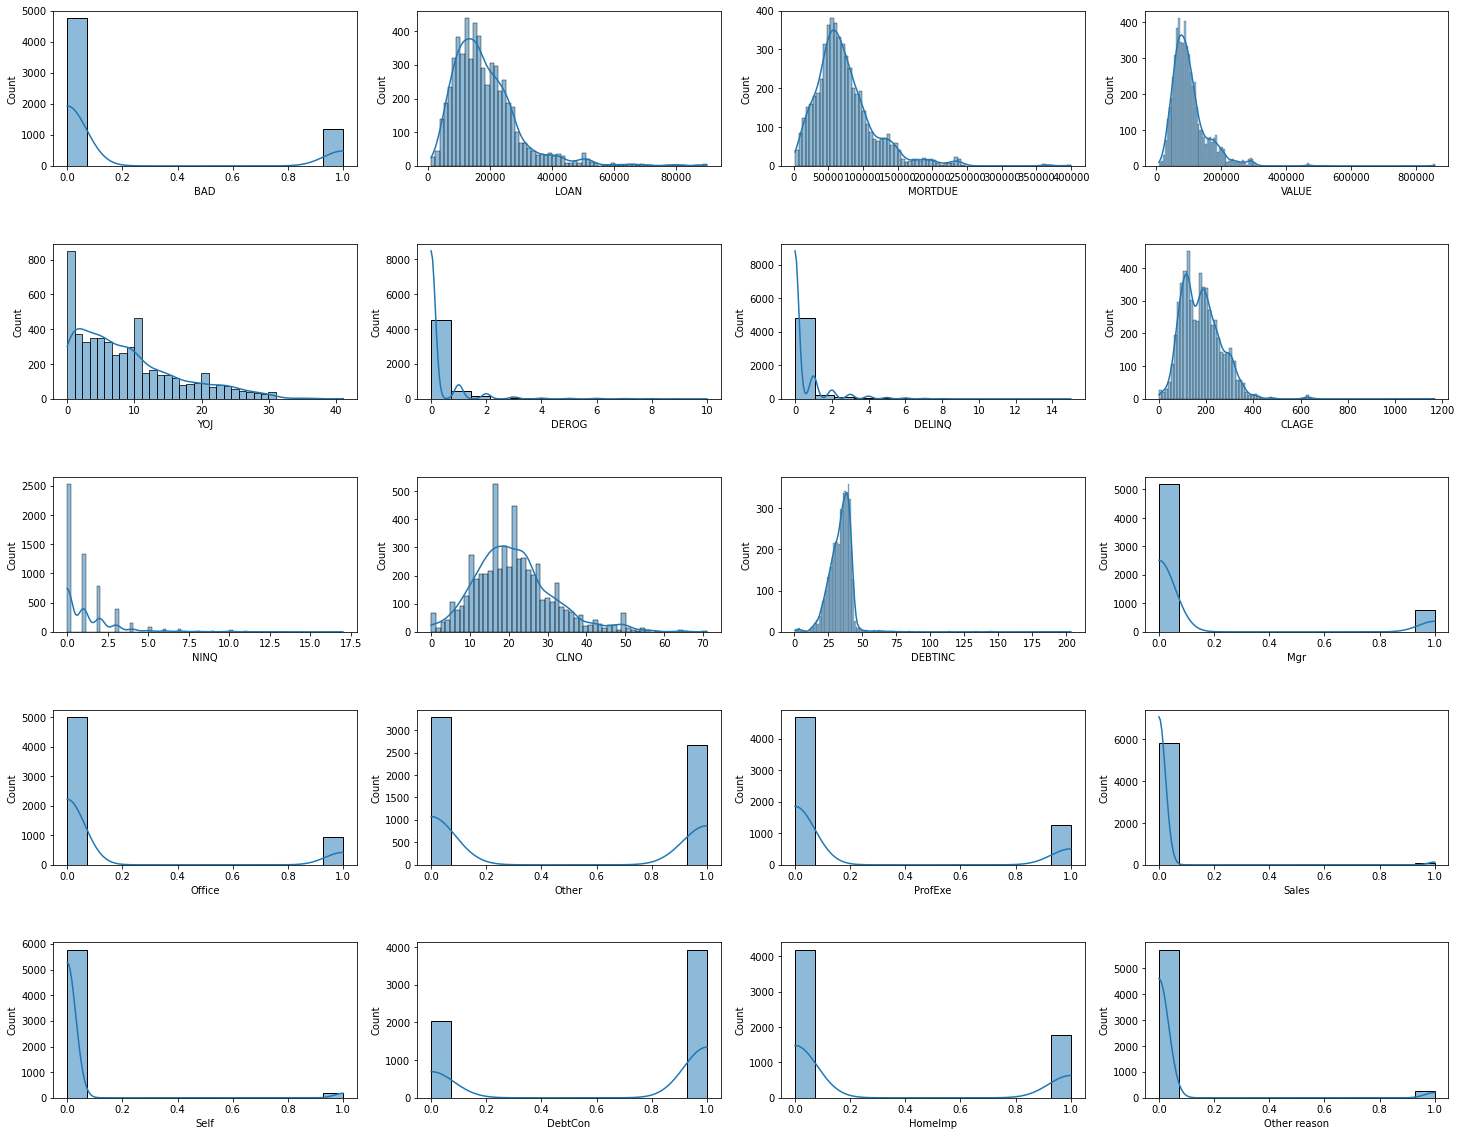

In [9]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i,ax in zip(df.columns,axes.flat):
    sns.histplot(data=df,x=i,ax=ax,kde=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


Plotting Heatmap of correlation Matrix, to understand the type of linear relation between attributes.<br>
We will also find the Predictive Power Score after filling the missing or null values to see the Non-Linear Relation between Attributes.

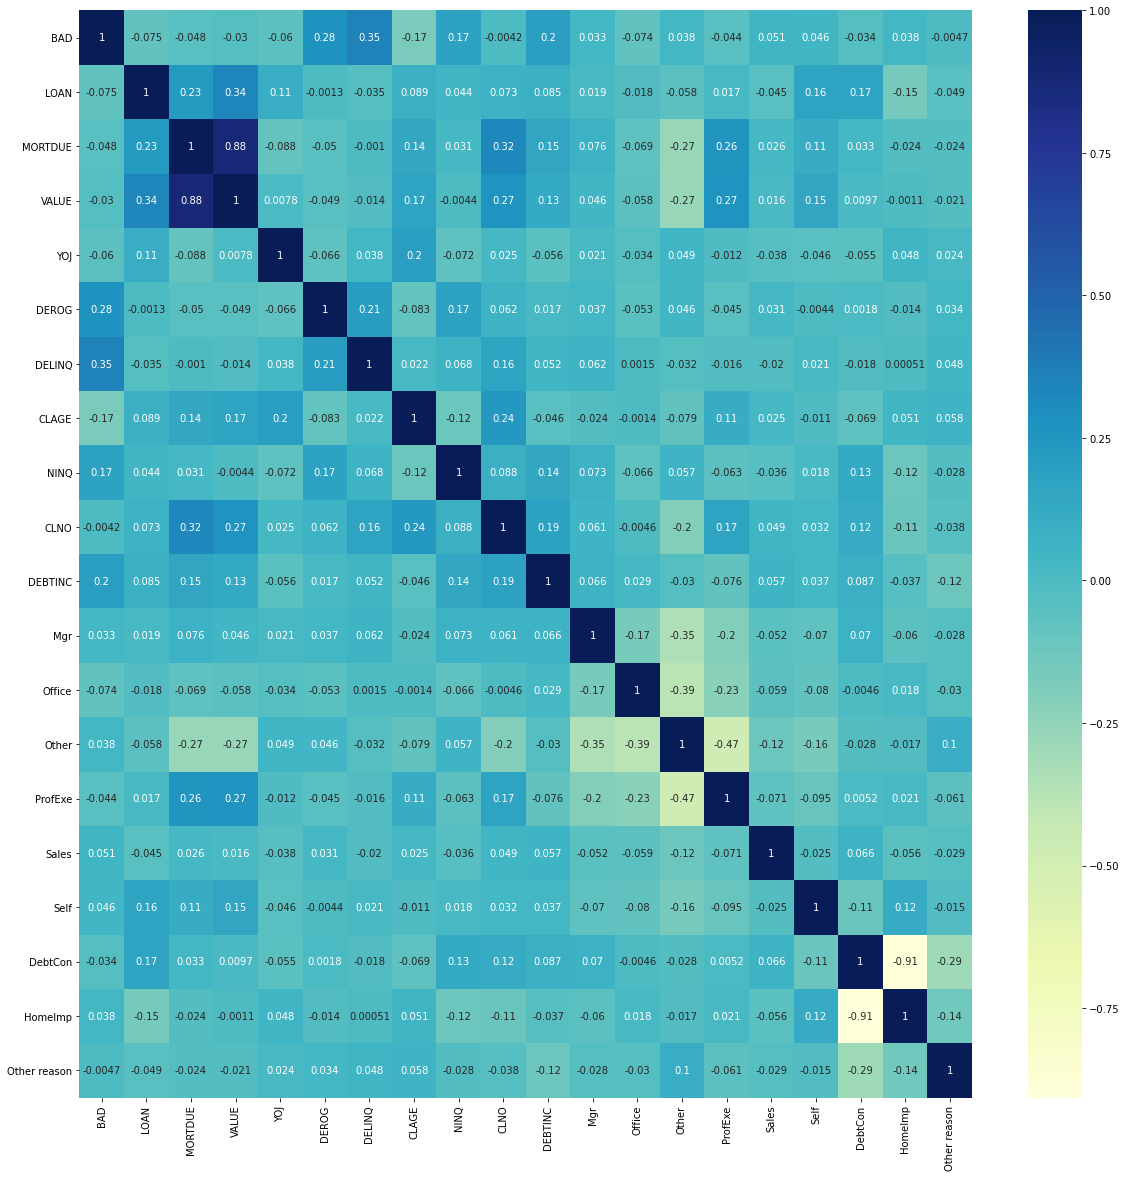

In [10]:
plt.figure(figsize=(20,20))
heat_map = sns.heatmap(df.corr(),cmap = "YlGnBu",annot=True)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
# sns.color_palette("mako", as_cmap=True)
plt.show()

In [11]:
# Calculating the number of missing values in each attributes
print(df.isna().sum())
# Number of rows/tuples where more than 3 attributes are missing
sum((df.isna().sum(axis=1))>3)

BAD                0
LOAN               0
MORTDUE          518
VALUE            112
YOJ              515
DEROG            708
DELINQ           580
CLAGE            308
NINQ             510
CLNO             222
DEBTINC         1267
Mgr                0
Office             0
Other              0
ProfExe            0
Sales              0
Self               0
DebtCon            0
HomeImp            0
Other reason       0
dtype: int64


308

We can consider those tuples where more than 3 attributes are missing

Reason/Meaning of null values in dataset, and how we will fill these:<br><br>
REASON - This shows the reason why the person is taking the loan. There are two available values : Debt consolidation and Home Improvement. Thus, missing value must denote that the reason was other than the two available options. So, we will fill the null values with _"Other reasons"_.

In [12]:
df[df["MORTDUE"].isna()]

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,Mgr,Office,Other,ProfExe,Sales,Self,DebtCon,HomeImp,Other reason
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1
9,1,2000,NaN,62250.0,16.0,0.0,0.0,115.800000,0.0,13.0,NaN,0,0,0,0,1,0,0,1,0
24,1,2400,NaN,17180.0,NaN,0.0,0.0,14.566667,3.0,4.0,NaN,0,0,1,0,0,0,0,1,0
40,1,3000,NaN,8800.0,2.0,0.0,1.0,77.766667,0.0,3.0,NaN,0,0,1,0,0,0,0,1,0
41,1,3000,NaN,33000.0,1.0,0.0,1.0,23.300000,1.0,2.0,NaN,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,53700,NaN,84205.0,NaN,0.0,0.0,339.665615,0.0,7.0,22.639940,0,0,1,0,0,0,0,1,0
5883,0,53800,NaN,81322.0,9.0,0.0,0.0,171.447555,0.0,22.0,24.709060,0,0,0,0,0,1,0,1,0
5884,0,53900,NaN,91309.0,NaN,0.0,0.0,349.795748,0.0,6.0,22.061330,0,0,1,0,0,0,0,1,0
5930,1,72300,NaN,85000.0,1.0,0.0,0.0,117.166667,9.0,23.0,NaN,0,0,1,0,0,0,1,0,0


In [11]:
# Temporary filling the rest null values with 0
df.fillna(0,inplace=True)

In [ ]:
# Using Predictive Power Score to see whether the attributes are independently able to predict the defaulters
# df_pps = df.join(y)
# score = pps.matrix(df_pps)
# print(score[score['y']=='BAD'])

In [20]:
def pps(df,categorical_features=None,numerical_features=None):
    columns = ["Feature", "Target","PPS", "Type of Prediction", "Cross-Val Score", "Training Score","Naive-Baseline Score", "Model"]
    pps_df=pd.DataFrame(columns=columns)
    for i in df.columns:
        for j in df.columns:
            if(j in categorical_features or type(df[j])==str):
                model = DecisionTreeClassifier()
                lab_enc = preprocessing.LabelEncoder()
                label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),label_encoded_y)
                model.fit(x_train,y_train)
                y_pred=model.predict(x_test)
                f1 = metrics.f1_score(y_test,y_pred)
                mode = np.full((len(x_test),1),df[j].mode())
                f1_naive = metrics.f1_score(y_test,mode)
                pps_score=max(0,(f1-f1_naive)/(1 - f1_naive))
                cv_score=model.score(x_test,y_test)
                train_score=model.score(x_train,y_train)
                pps_df = pps_df.append({"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Classification","Cross-Val Score":cv_score,"Training Score":train_score,"Naive-Baseline Score":f1_naive,"Model":"DecisionTreeClassifier()"},ignore_index=True)
            else:
                model = DecisionTreeRegressor()
                # lab_enc = preprocessing.LabelEncoder()
                # label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),np.array(df[j]).reshape(-1,1))
                model.fit(x_train,y_train)
                median = np.full((len(x_test),1),df[j].median())
                naive_mae = metrics.mean_absolute_error(y_test, median)
                y_pred=model.predict(x_test)
                mae=metrics.mean_absolute_error(y_test,y_pred)
                train_score=model.score(x_train,y_train)
                pps_score = max(0,1 - mae/naive_mae)
                pps_df=pps_df.append({"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Regression","Cross-Val Score":cv_score,"Training Score":train_score,"Naive-Baseline Score":naive_mae,"Model":"DecisionTreeRegressor()"},ignore_index=True)
    
    return pps_df
categ = ["BAD"]
pps_f = pps(df,categ)

In [23]:
pps_f[pps_f["Target"]=="BAD"]

,Feature,Target,PPS,Type of Prediction,Cross-Val Score,Training Score,Naive-Baseline Score,Model
0,BAD,BAD,1.000000,Classification,1.000000,1.000000,0.0,DecisionTreeClassifier()
20,LOAN,BAD,0.282297,Classification,0.798658,0.823714,0.0,DecisionTreeClassifier()
40,MORTDUE,BAD,0.271012,Classification,0.714765,0.961074,0.0,DecisionTreeClassifier()
60,VALUE,BAD,0.336163,Classification,0.737584,0.973826,0.0,DecisionTreeClassifier()
80,YOJ,BAD,0.104348,Classification,0.792617,0.822819,0.0,DecisionTreeClassifier()
100,DEROG,BAD,0.242254,Classification,0.819463,0.809620,0.0,DecisionTreeClassifier()
120,DELINQ,BAD,0.292683,Classification,0.824832,0.815436,0.0,DecisionTreeClassifier()
140,CLAGE,BAD,0.281739,Classification,0.722819,0.969575,0.0,DecisionTreeClassifier()
160,NINQ,BAD,0.132530,Classification,0.806711,0.799776,0.0,DecisionTreeClassifier()
180,CLNO,BAD,0.049470,Classification,0.819463,0.802013,0.0,DecisionTreeClassifier()


In [14]:
df["BAD"].mode()

0    0
dtype: int64

Building the Model

In [ ]:
# Dividing the dataset into training and cross-validation
y = df["BAD"]
df.drop(["BAD"],axis=1,inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df,y)

In [ ]:
# Training Decision Tree Model
dtree = DecisionTreeClassifier()
dtree.fit(x_train,y_train)

Testing the models on cross-validation dataset, and comparing with training dataset

In [ ]:
print("Accuracy on Training Dataset : ",dtree.score(x_train,y_train))
print("Accuracy on CV Dataset : ",dtree.score(x_test,y_test))